# Density × speed-transfer decay sweep

Sweeps density (controls agents per group) and speed-transfer decay to see how much rhythmicity leaks into the nominally non-rhythmic group.

- Agents per group = `500 * density_factor` (so 0.40 ≈ 200 agents).
- Day duration: 200 steps; simulation length: 800 steps (4 days).
- Defaults otherwise unchanged; `.mat` saving disabled for speed.

In [40]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from simulation import (
    AblationConfig,
    OutputOptions,
    SimulationParameters,
    default_simulation_config,
    run_ablation_study,
)

plt.style.use("seaborn-v0_8")

In [41]:
# Sweep definition
# Adjust these for the sweep; script/caching will respect these values
# and reuse results when possible.
density_factors = [0.20, 0.40, 0.60, 0.80, 1.00, 1.20]
speed_transfer_decays = [0.0, 0.4, 0.8, 0.95]
num_runs = 5
rhythmicity_permutations = 100
day_duration = 300
sim_duration = 1200
seed = 42
force_recompute = False

cache_file = Path("visualizations/sweep_cache/density_decay_sweep.csv")
plot_prefix = Path("visualizations/output/density_decay_sweep")


In [42]:
agg_file = cache_file.with_name(cache_file.stem + "_agg.csv")

should_run = force_recompute or not agg_file.exists()

if should_run:
    cmd = [
        "python",
        "run_density_decay_sweep.py",
        "--density-factors",
        ",".join(f"{d:.2f}" for d in density_factors),
        "--decays",
        ",".join(f"{d:.2f}" for d in speed_transfer_decays),
        "--num-runs",
        str(num_runs),
        "--rhythmicity-permutations",
        str(rhythmicity_permutations),
        "--day-duration",
        str(day_duration),
        "--sim-duration",
        str(sim_duration),
        "--seed",
        str(seed),
        "--cache-file",
        str(cache_file),
        "--plot-prefix",
        str(plot_prefix),
    ]
    if force_recompute:
        cmd.append("--force-recompute")
    print("Running sweep script:", " ".join(cmd))
    import subprocess

    res = subprocess.run(cmd, capture_output=True, text=True)
    print(res.stdout)
    if res.returncode != 0:
        print(res.stderr)
        res.check_returncode()
else:
    print(f"Found aggregated results at {agg_file}; loading without rerunning. Delete cache to recompute.")

agg_df = pd.read_csv(agg_file)
raw_df = pd.read_csv(cache_file) if cache_file.exists() else None
agg_df.head()


Running sweep script: python run_density_decay_sweep.py --density-factors 0.20,0.40,0.60,0.80,1.00,1.20 --decays 0.00,0.40,0.80,0.95 --num-runs 5 --rhythmicity-permutations 100 --day-duration 300 --sim-duration 1200 --seed 42 --cache-file visualizations/sweep_cache/density_decay_sweep.csv --plot-prefix visualizations/output/density_decay_sweep
Loaded cached sweep results from visualizations/sweep_cache/density_decay_sweep.csv. Delete this file to force recompute after model changes.
Wrote aggregated sweep to visualizations/sweep_cache/density_decay_sweep_agg.csv
Saved plots to visualizations/output/density_decay_sweep_heatmaps.png and visualizations/output/density_decay_sweep_lines.png



,density_factor,speed_transfer_decay,agents_per_group,amplitude_group2_mean,amplitude_group2_std,amplitude_group2_count,amplitude_group1_mean,amplitude_group1_std,phase_shift_mean,phase_shift_std,amplitude_group2_sem,amplitude_group2_ci95
0,0.2,0.00,100.0,0.015291,0.002189,5,1.250802,0.003217,4.111357,7.525904,0.000979,0.001919
1,0.2,0.40,100.0,0.018010,0.002250,5,1.252753,0.003095,11.484133,16.994736,0.001006,0.001972
2,0.2,0.80,100.0,0.064346,0.005779,5,1.252567,0.001887,17.880986,9.714101,0.002585,0.005066
3,0.2,0.95,100.0,0.190228,0.016312,5,1.245406,0.004609,20.786926,6.132461,0.007295,0.014298
4,0.4,0.00,200.0,0.027222,0.004345,5,1.248716,0.003156,2.405929,8.776775,0.001943,0.003809


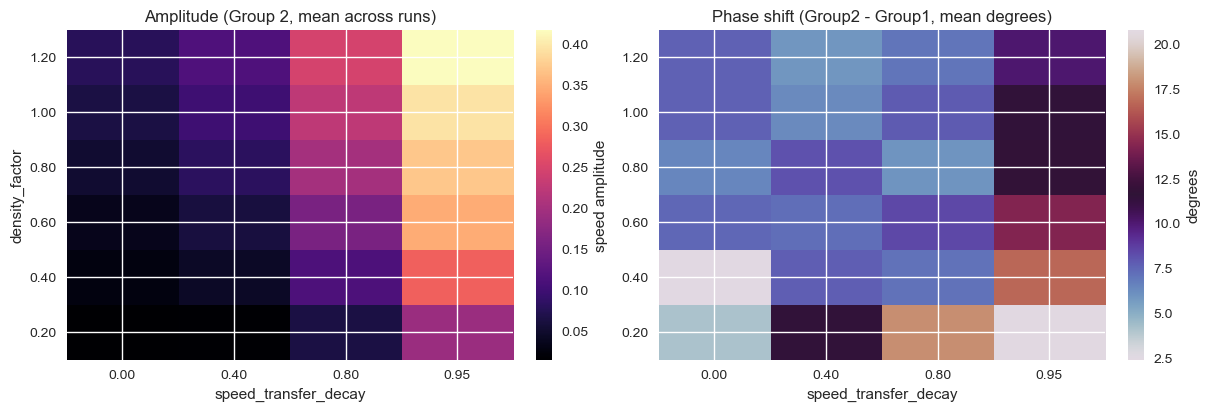

In [ ]:
# Heatmaps for non-rhythmic group metrics (mean across runs)
pivot_amp = agg_df.pivot(
    index="density_factor", columns="speed_transfer_decay", values="amplitude_group2_mean"
).sort_index()
pivot_phase = agg_df.pivot(
    index="density_factor", columns="speed_transfer_decay", values="phase_shift_mean"
).sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

im0 = axes[0].imshow(pivot_amp.values, origin="lower", aspect="auto", cmap="magma")
axes[0].set_xticks(range(len(pivot_amp.columns)))
axes[0].set_xticklabels([f"{c:.2f}" for c in pivot_amp.columns])
axes[0].set_yticks(range(len(pivot_amp.index)))
axes[0].set_yticklabels([f"{r:.2f}" for r in pivot_amp.index])
axes[0].set_xlabel("speed_transfer_decay")
axes[0].set_ylabel("density_factor")
axes[0].set_title("Amplitude (Group 2, mean across runs)")
fig.colorbar(im0, ax=axes[0], label="speed amplitude")

im1 = axes[1].imshow(pivot_phase.values, origin="lower", aspect="auto", cmap="magma")
axes[1].set_xticks(range(len(pivot_phase.columns)))
axes[1].set_xticklabels([f"{c:.2f}" for c in pivot_phase.columns])
axes[1].set_yticks(range(len(pivot_phase.index)))
axes[1].set_yticklabels([f"{r:.2f}" for r in pivot_phase.index])
axes[1].set_xlabel("speed_transfer_decay")
axes[1].set_title("Phase shift (Group2 - Group1, mean degrees)")
fig.colorbar(im1, ax=axes[1], label="degrees")

plt.show()


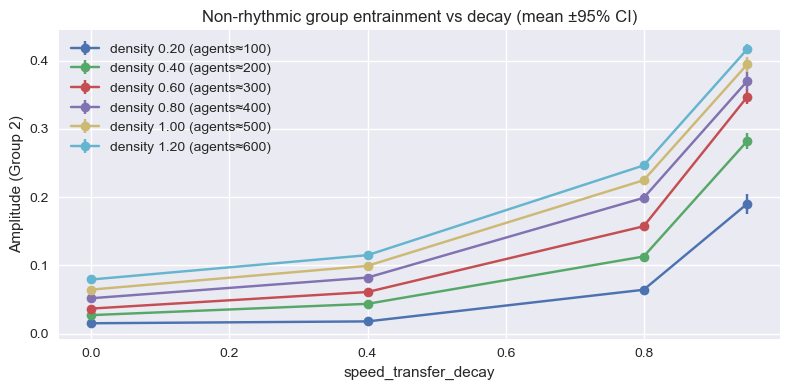

In [44]:
# Line view: amplitude of non-rhythmic group across decay for each density (mean ± 95% CI)
if "amplitude_group2_ci95" not in agg_df:
    agg_df["amplitude_group2_sem"] = agg_df["amplitude_group2_std"] / np.sqrt(agg_df["amplitude_group2_count"].clip(lower=1))
    agg_df["amplitude_group2_ci95"] = 1.96 * agg_df["amplitude_group2_sem"]

fig, ax = plt.subplots(figsize=(8, 4))
for density in density_factors:
    subset = agg_df[agg_df["density_factor"] == density].sort_values("speed_transfer_decay")
    ax.errorbar(
        subset["speed_transfer_decay"],
        subset["amplitude_group2_mean"],
        yerr=subset["amplitude_group2_ci95"],
        marker="o",
        capsize=4,
        label=f"density {density:.2f} (agents≈{int(500*density)})",
    )
ax.set_xlabel("speed_transfer_decay")
ax.set_ylabel("Amplitude (Group 2)")
ax.set_title("Non-rhythmic group entrainment vs decay (mean ±95% CI)")
ax.legend()
plt.tight_layout()
plt.show()


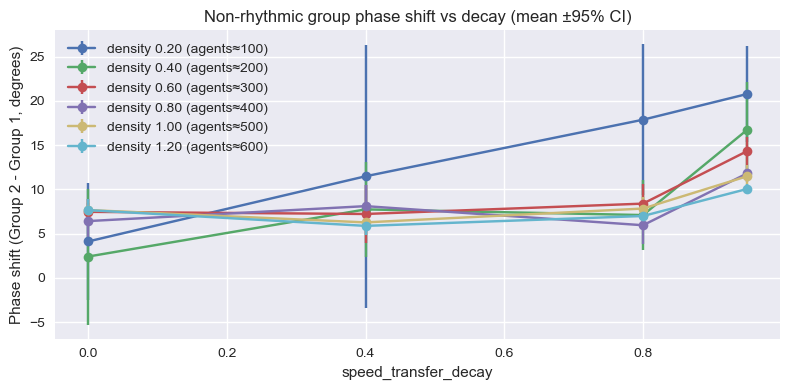

In [45]:
# Line view: Phase of non-rhythmic group across decay for each density (mean ± 95% CI)
fig, ax = plt.subplots(figsize=(8, 4))
for density in density_factors:
    subset = agg_df[agg_df["density_factor"] == density]
    ax.errorbar(
        subset["speed_transfer_decay"],
        subset["phase_shift_mean"],
        yerr=subset["phase_shift_std"] * 1.96 / np.sqrt(subset["amplitude_group2_count"].clip(lower=1)),
        marker="o",
        capsize=4,
        label=f"density {density:.2f} (agents≈{int(500*density)})",
    )
ax.set_xlabel("speed_transfer_decay")
ax.set_ylabel("Phase shift (Group 2 - Group 1, degrees)")
ax.set_title("Non-rhythmic group phase shift vs decay (mean ±95% CI)")
ax.legend()
plt.tight_layout()
plt.show()
